In [1]:
import torch
from tqdm.notebook import tqdm 
from sklearn import metrics
import numpy as np 

from dataset.localization_test_ds import get_test_localization_ds
from models.model9 import DesnseNet121

import torch.nn as nn

torch.manual_seed(41)

# Dataset and Dataloader 

In [2]:
import json
from easydict import EasyDict as edict

config = None
with open('./config/example.json') as f:
    config = edict(json.load(f))

In [3]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([transforms.ToPILImage(), 
                    transforms.Resize(224),
                    transforms.ToTensor(),
                    normalize])

In [4]:
dataset_test = get_test_localization_ds()

In [5]:
a, b, c, d, e = dataset_test[1]

# Model Define

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = DesnseNet121(num_classes=15)
model = model.to(device)
'''
with torch.no_grad():
    # class_preds, class_hms = model(torch.randn(2, 3, 224, 224).to('cuda'), torch.randn(2, 15, 224, 224).to('cuda'))
    class_preds, class_hms = model(torch.randn(2, 3, 224, 224).to('cuda'))
'''

"\nwith torch.no_grad():\n    # class_preds, class_hms = model(torch.randn(2, 3, 224, 224).to('cuda'), torch.randn(2, 15, 224, 224).to('cuda'))\n    class_preds, class_hms = model(torch.randn(2, 3, 224, 224).to('cuda'))\n"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

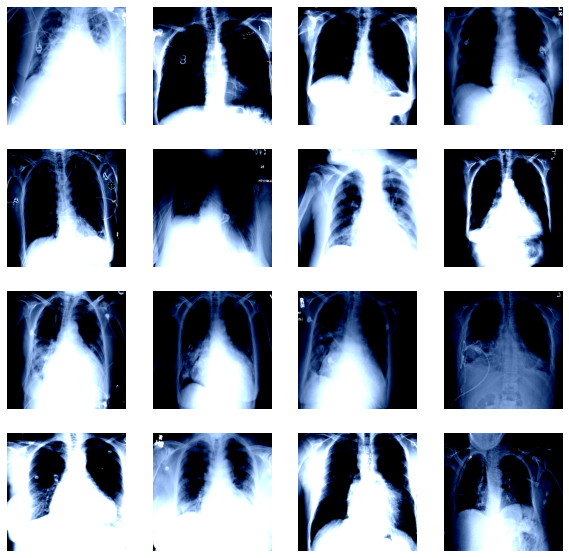

In [7]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,10))
dataiter = iter(dataset_test)

for i in range(16):
    img, _, _, _, _ = next(dataiter)
    # img = cfg.pixel_std * img + cfg.pixel_mean
    plt.subplot(4,4,i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
plt.show()

# Train-Test Functions

In [8]:
@torch.no_grad()
def test():
    model.eval()
    predlist = [[] for i in range(num_diseases)]
    truelist = [[] for i in range(num_diseases)]
    loss_list = []

    for images, abnorm_masks, lung_mask, class_label_gts, bbox_gts in testloader:
        images = images.to(device)
        # lung_mask = lung_mask.to(device)
        abnorm_masks = abnorm_masks.to(device)
        # bbox_gts = bbox_gts.to(device)
        class_label_gts = class_label_gts.to(device)
        
        class_label_preds, _ = model(images, abnorm_masks)
        # class_label_preds, _ = model(images)
        loss = loss_function(class_label_preds[:, :8], class_label_gts)
        loss_list .append(loss.item())
        
        for i in range(num_diseases):
            pred = torch.sigmoid(class_label_preds[:,i]).cpu().detach().numpy()
            predlist[i] = np.append(predlist[i], pred)
            truelist[i] = np.append(truelist[i], class_label_gts[:,i].cpu().detach().numpy())
            
    predlist = np.array(predlist)
    truelist = np.array(truelist)
    loss_list = np.array(loss_list)
    loss_list = loss_list.mean()

    auclist = []
    acclist = []

    for i in range(num_diseases):
        y_pred = predlist[i]
        y_true = truelist[i]
                    
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label = 1)
        auc = metrics.auc(fpr, tpr)
        auclist.append(auc)
        acc = metrics.accuracy_score(y_true,y_pred>0.5)
        acclist.append(acc)
    auc_mean = np.array(auclist).mean()
    acc_mean = np.array(acclist).mean()
            
    model.train()


    print("Auc:",auclist,"  auc mean: ", auc_mean)
    print("Loss mean", loss_list)
    return auclist, auc_mean, acc_mean, loss_list.sum()

# Training Parameters

In [9]:
batch_size = 1
num_diseases = 8
resume = False

In [10]:
testloader = torch.utils.data.DataLoader(
                    dataset_test, batch_size=batch_size,
                    drop_last = False)

In [11]:
loss_function = nn.BCEWithLogitsLoss()

# Training Phase

In [12]:
from eval import show_overlayed_heatmap, process_heatmap, process_image, process_bbox_gts, show_overlayed_bboxes

In [13]:
model= torch.load("./runs/model9exp1/best.ckpt")['model']
model.eval()

DesnseNet121(
  (backbone): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

In [14]:
# auclist, auc_mean, acc_mean, loss = test()

## IOU & IOBB Calculation

In [15]:
from eval import heatmap_to_bboxes, iou, iobb

In [16]:
def iou_iobb_calc(model, test_loader):
    '''
    test_loader of batch_size = 1
    '''
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    ious = np.zeros(8)
    iobbs = np.zeros(8)
    for images, abnorm_masks, lung_mask, label, bboxes in testloader:
        images = images.to(device)
        lung_mask = lung_mask.to(device)
        abnorm_masks = abnorm_masks.to(device)
        # abnorm_masks[:, 3, :, :] = lung_mask[:, 0, :, :]
        # label = label.to(device)
        pred, heatmap = model(images, abnorm_masks, lung_mask)  # pred, heatmap = model(images, abnorm_masks)
        heatmap = process_heatmap(heatmap[0] * torch.sigmoid(pred[0]).reshape(-1, 1, 1)) # D, H, W
        bbox_preds = heatmap_to_bboxes(heatmap)
        bbox_gts = bboxes[0].detach().cpu().numpy() # D, 4
        ious += iou(bbox_preds, bbox_gts)
        iobbs += iobb(bbox_preds, bbox_gts)
    
    ious = ious / len(test_loader)
    iobbs = iobbs / len(test_loader)
    return ious, iobbs

In [17]:
def iou_iobb_accuracy(model, test_loader, thresh = 0.1):
    '''
    test_loader of batch_size = 1
    '''
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    iou_acc = np.zeros(8)
    iobb_acc = np.zeros(8)
    for image, abnorm_masks, lung_mask, label, bboxes in test_loader:
        abnorm_masks = torch.cat((abnorm_masks, torch.ones((1, 7, 224, 224), dtype=torch.float32)), dim=1)
        image = image.to(device)
        lung_mask = lung_mask.to(device)
        abnorm_masks = abnorm_masks.to(device)
        # abnorm_masks[:, 3, :, :] = lung_mask[:, 0, :, :]
        # label = label.to(device)
        pred, heatmap = model(image, abnorm_masks, lung_mask) # pred, heatmap = model(image, abnorm_masks)
        heatmap = process_heatmap(heatmap[0] * torch.sigmoid(pred[0]).reshape(-1, 1, 1)) # D, H, W
        bbox_preds = heatmap_to_bboxes(heatmap)
        bbox_gts = bboxes[0].detach().cpu().numpy() # D, 4
        iou_score = iou(bbox_preds, bbox_gts) > thresh
        iobb_score = iobb(bbox_preds, bbox_gts) > thresh
        iou_acc += iou_score
        iobb_acc += iobb_score
    
    iou_acc = iou_acc / len(test_loader)
    iobb_acc = iobb_acc / len(test_loader)
    return iou_acc, iobb_acc

In [18]:
for i in range(1, 4, 2):
    ious, iobbs = iou_iobb_accuracy(model, testloader, thresh=0.1*i)
    print(i*0.1, " :")
    print(ious, iobbs)

0.1  :
[0.54886364 0.73068182 0.07840909 0.37727273 0.61931818 0.76136364
 0.86363636 0.62954545] [0.03295455 0.14545455 0.05454545 0.06136364 0.02045455 0.
 0.         0.0375    ]
0.30000000000000004  :
[0.52159091 0.67727273 0.02840909 0.33181818 0.60795455 0.76136364
 0.86363636 0.59772727] [0.00454545 0.09545455 0.00454545 0.01931818 0.00795455 0.
 0.         0.00568182]


## Heatmap Generation

In [38]:
idx = 113 # 830, 310, 275, 210, 113
itr = iter(testloader)

for i in range(idx):
    image, abnorm_mask, lung_mask, label, bboxes = next(itr)
    abnorm_mask = torch.cat((abnorm_mask, torch.ones(1, 7, 224, 224, dtype=torch.float32)), dim=1)
    
with torch.no_grad():
    image = image.to(device)
    abnorm_mask = abnorm_mask.to(device)
    lung_mask = lung_mask.to(device)
    # abnorm_mask[:, 3, :, :] = lung_mask[:, 0, :, :]
    pred, heatmap = model(image, abnorm_mask) # pred, heatmap = model(image, abnorm_mask) 
processesd_image = process_image(image[0])
processed_heatmap = process_heatmap(heatmap[0] * torch.sigmoid(pred[0]).reshape(-1, 1, 1))

In [39]:
score = torch.sigmoid(pred[0].detach().cpu()).numpy()
score[:8], label

(array([0.13879628, 0.40017822, 0.23428635, 0.14345653, 0.17411174,
        0.03504381, 0.01195425, 0.00717552], dtype=float32),
 tensor([[0., 1., 0., 0., 0., 0., 0., 0.]]))

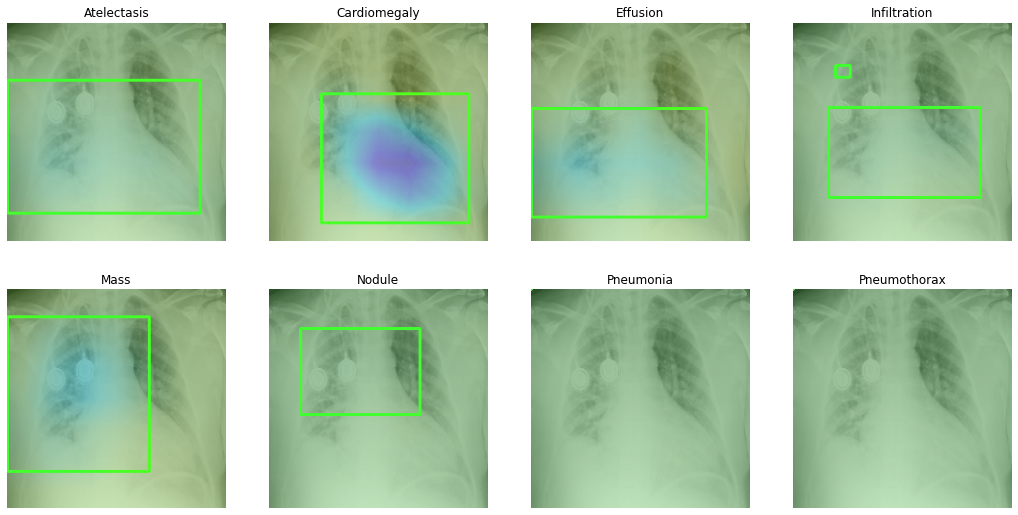

In [40]:

show_overlayed_heatmap(processesd_image, processed_heatmap, mode=3)

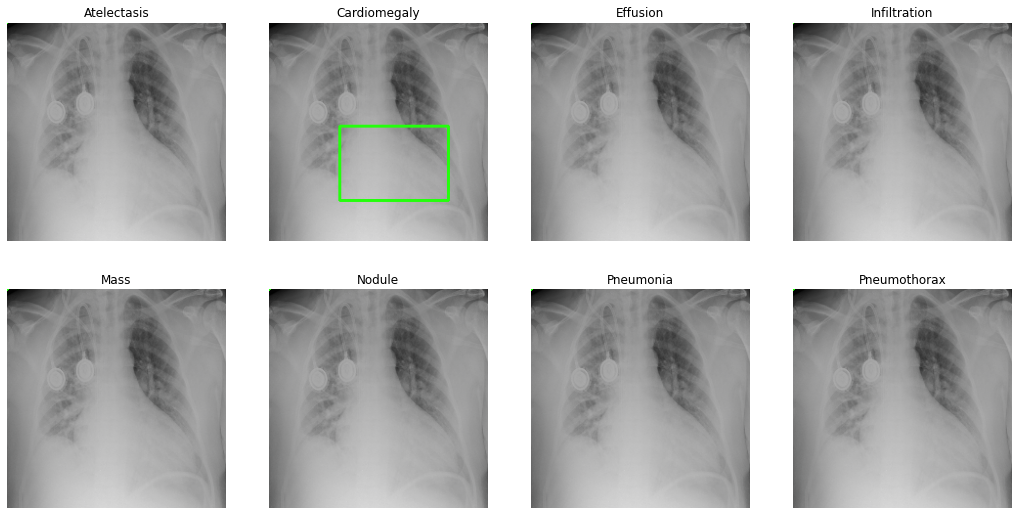

In [41]:
show_overlayed_bboxes(processesd_image, process_bbox_gts(bboxes[0]))